# 작사가 만들기
---

# 0. 환경

* Ubuntu 18.04
* TensorFlow 2.4.1
* scikit learn 0.23.0
* numpy 1.19.5
* Keras 2.4.3
* conda 4.10.1

# 1. 데이터 다운로드

* shell 환경에 다운 받아져 있는 데이터 불러오기
 * mkdir -p ~/aiffel/lyricist/models
 * ln -s ~/data ~/aiffel/lyricist/data

# 2. 데이터 읽어오기

In [1]:
import glob
import os
import re
import numpy as np
import tensorflow as tf
from keras.layers import Bidirectional, LSTM, GRU, Dense, Embedding
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 

* splitlines() = 여러개의 줄로 이루어진 문자열을 한 줄씩 구분하여 리스트 생성, 

In [2]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['At first I was afraid', 'I was petrified', 'I kept thinking I could never live without you']


# 3. 데이터 정제

In [3]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 15: break   # 문장 확인 
        
    print(sentence)

At first I was afraid
I was petrified
I kept thinking I could never live without you
By my side But then I spent so many nights
Just thinking how you've done me wrong
I grew strong
I learned how to get along And so you're back
From outer space
I just walked in to find you
Here without that look upon your face I should have changed that fucking lock
I would have made you leave your key
If I had known for just one second
You'd be back to bother me Well now go,
Walk out the door
Just turn around
Now, you're not welcome anymore Weren't you the one


# 3-1. 정규표현식(Regex)을 통한 처리

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 
    sentence = sentence.strip() 
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [5]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> at first i was afraid <end>',
 '<start> i was petrified <end>',
 '<start> i kept thinking i could never live without you <end>',
 '<start> by my side but then i spent so many nights <end>',
 '<start> just thinking how you ve done me wrong <end>',
 '<start> i grew strong <end>',
 '<start> i learned how to get along and so you re back <end>',
 '<start> from outer space <end>',
 '<start> i just walked in to find you <end>',
 '<start> here without that look upon your face i should have changed that fucking lock <end>']

# 4. Tokenize

* maxlen = 15 : 최대 길이를 15까지로 맞춤(0~14개의 index)
* truncating = 'post' : 시퀀스의 끝 부분 자름(maxlen과 같이 쓸 수 있음.)
 * truncating은 pre로 할 경우 시퀀스의 시작 부분을 자름

In [6]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
def tokenize(corpus):
    # 문장을 정제하려면 filters를 사용. 그러나 앞에 정제화를 했기때문에 필요없음
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 가장 빈도가 높은 num_word개의 단어만 선택
        filters=' ',       
        oov_token="<unk>" # word_index에 추가, text_to_sequence 호출 중에 어휘 외의 단어를 대체하는 데 사용
    )
    
    # 1. corpus를 이용해 tokenizer 내부의 단어장을 완성합니다.(단어 인덱스 구축)
    # 2. 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # 3. 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 3. 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 3. 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다.
    # 3. maxlen=None은 모든 시퀀스의 최대 길이. 제공하지 않으면 시퀀스가 가장 긴 개별 시퀀스의 길이로 채워짐
    tokenizer.fit_on_texts(corpus)                                                            # 1
    tensor = tokenizer.texts_to_sequences(corpus)                                             # 2   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           maxlen=15, 
                                                           padding='post',
                                                           truncating='post')                 # 3
                                                             
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus) 

[[   2   71  241 ...    0    0    0]
 [   2    5   57 ...    0    0    0]
 [   2    5 1094 ...    0    0    0]
 ...
 [   2   48   16 ...    0    0    0]
 [   2    5   22 ...   32   15   43]
 [   2    6  180 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fa1ad49ce90>


In [7]:
# 데이터 확인

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [8]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2  71 241   5  57 664   3   0   0   0   0   0   0   0]
[ 71 241   5  57 664   3   0   0   0   0   0   0   0   0]


# 6-1. 데이터셋 분리(train_test_split)

* 데이터셋을 두가지 방법으로 나누는 방법을 생각했었음.
  
  전부 사용을 해봤으며 2번으로 정리. 

1. tf.data.datasets에서 take와 skip
2. sklearn.model_selection의 train_test_split

In [11]:
# train_dataset = dataset.take(124960)    # 데이터셋의 124960개 이후 나머지
# test_dataset = dataset.skip(124960)     # 데이터셋의 처음 124960개
# print(train_dataset)
# print(test_dataset)

In [12]:
# 데이터셋 분리
enc_train, enc_val, dec_train, dec_val = \
train_test_split(src_input, tgt_input, test_size=0.2) # shuffle=False

# 6-2. 데이터셋 분리(tf.data.dataset)

In [9]:
# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
# print('# 1 :', dataset)
# dataset = dataset.shuffle(BUFFER_SIZE)
# print('# 2 :', dataset)
# dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
# print('# 3 :', dataset)
# dataset

In [10]:
#dataset이 어떻게 생겼는지 확인
# for element in dataset.as_numpy_iterator():
#     print(element)

# Hyperparameter Batch_Size

* 전체 데이터를 batch_size 만큼 나누어서 학습시킬 때 사용

In [13]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE 
print(steps_per_epoch)
 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

686


# 6-3. 진행결과 확인

In [14]:
print(enc_train.shape)
print(dec_train.shape)
print('-'*30)
print(enc_val.shape)
print(dec_val.shape)

(140599, 14)
(140599, 14)
------------------------------
(35150, 14)
(35150, 14)


# 7. 인공지능 만들기

* 1차 시도(loss = 2.3xx)
 * 2 LSTM, 1 Dense
  * embeding_size = 512, hidden_size = 1024, batch_size = 512
* 2차 시도(loss = 2.39x)
 * 2 GRU, 1 Dense
  * embeding_size = 512, hidden_size = 1024, batch_size = 512
* 3차 시도(loss = 2.1)
 * 2 LSTM (dropout= 0.2), 1 Dense
  * embeding_size = 512, hidden_size = 1024, batch_size = 512
* 4차 시도(loss = 1.8, val_loss = 1.6) 
 * 2 LSTM (dropout = 0.5), 1 Dense
  * embeding_size = 256, hidden_size = 1024, batch_size = 512
* 5차 시도(loss = 0.012 , test_loss = 0.1946 , val_loss = 0.1908)
 * 2 Bidirectional LSTM(dropout=0.5), 1 Dense
  * embeding_size = 256, hidden_size = 1024, batch_size = 512
* n차 시도(loss = 0.07, test_loss = 0.25, val_loss = 0.26 )
 * 1 LSTM, 1 Bidirectional LSTM, 3 Dropout
  * embeding_size = 256, hidden_size = 1024, batch_size = 512

In [15]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        # Embedding 층은 두 개의 매개변수를 받음.
        self.embedding = Embedding(vocab_size, embedding_size)
        self.dropout_1 = Dropout(0.5) 
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.dropout_2 = Dropout(0.5)
        self.rnn_2 = Bidirectional(LSTM(hidden_size, return_sequences=True))
        self.dropout_3 = Dropout(0.5)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.dropout_1(out)
        out = self.rnn_1(out)
        out = self.dropout_2(out)
        out = self.rnn_2(out)
        out = self.dropout_3(out)
        out = self.linear(out)
        
        return out
    
    
embedding_size = 256   # 원래 256
hidden_size = 1024     # 원래 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

* optimizer = Adam 추가

In [16]:
# optimizer, loss

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, # Softmax를 통해 정규화 되지 않은 네트워크의 출력
    reduction='none'  # 범주형 교차 엔트로피 label*log(pred)의 각 요소 제공
)

In [17]:
# model.fit

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, dec_train, epochs=10, validation_split=0.25)
print(history.history)

Epoch 1/10
3296/3296 [==============================] - 495s 148ms/step - loss: 2.4102 - val_loss: 0.7044
Epoch 2/10
3296/3296 [==============================] - 488s 148ms/step - loss: 0.7235 - val_loss: 0.4551
Epoch 3/10
3296/3296 [==============================] - 487s 148ms/step - loss: 0.4420 - val_loss: 0.3478
Epoch 4/10
3296/3296 [==============================] - 486s 148ms/step - loss: 0.2863 - val_loss: 0.2972
Epoch 5/10
3296/3296 [==============================] - 486s 148ms/step - loss: 0.1987 - val_loss: 0.2756
Epoch 6/10
3296/3296 [==============================] - 486s 148ms/step - loss: 0.1452 - val_loss: 0.2647
Epoch 7/10
3296/3296 [==============================] - 485s 147ms/step - loss: 0.1146 - val_loss: 0.2559
Epoch 8/10
3296/3296 [==============================] - 485s 147ms/step - loss: 0.0950 - val_loss: 0.2558
Epoch 9/10
3296/3296 [==============================] - 485s 147ms/step - loss: 0.0834 - val_loss: 0.2531
Epoch 10/10
3296/3296 [=======================

# 8. 시각화(Train / Test)

* model.fit에서 진행된 내역을 history 변수에 담아 tf에서 제공하는 history를 통해 epoch당 loss로 시각화
* 10 epoch에서 약간의 loss 상승

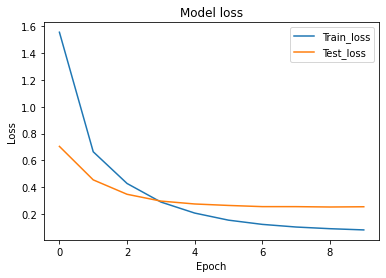

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train_loss', 'Test_loss'], loc='best')
plt.show()

# 9. 검증

* train_test_split을 통해 나눴던 validation set을 통해 검증
* 데이터를 초기 완전 분할했던 데이터

In [19]:
results = model.evaluate(enc_val, dec_val)
print('Val_loss:', results)

1099/1099 [==============================] - 50s 46ms/step - loss: 0.2617
Val_loss: 0.2617027163505554


# 10. 문장 Test

In [20]:
 def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

# 10-1. 다양한 문장 Test

In [38]:
generate_text(model, tokenizer, init_sentence="<start> love", max_len=15)

'<start> love you , baby <end> '

In [22]:
generate_text(model, tokenizer, init_sentence="<start> so ", max_len=15)

'<start> so many , i m gonna be tough <end> '

In [23]:
generate_text(model, tokenizer, init_sentence="<start> i love ", max_len=15)

'<start> i love you at the corner , i m suppose , i m a '

In [24]:
generate_text(model, tokenizer, init_sentence="<start> boy ", max_len=15)

'<start> boy , i m a caesar <end> '

In [46]:
generate_text(model, tokenizer, init_sentence="<start> you love", max_len=15)

'<start> you love me <end> '

In [26]:
generate_text(model, tokenizer, init_sentence="<start> every one ", max_len=15)

'<start> every one , i m so sorry <end> '

In [50]:
generate_text(model, tokenizer, init_sentence="<start> why", max_len=15)

'<start> why i m a flirt <end> '

In [63]:
generate_text(model, tokenizer, init_sentence="<start> have", max_len=15)

'<start> have is that i m not taking <end> '

# 11. 정리 및 생각

* 새벽시간대에는 1epoch 당 20~30분씩 걸렸음.
 * 낮시간은 1epoch 당 7~8분 소요
* LSTM의 개선된 모델이 GRU로 알고 있었고 속도적인 측면에서 GRU가 더 좋다고 생각했으나 찾아보고 경험한 결과 다음과 같은 결과를 얻었음.
 * GRU는 적은 데이터셋에서 빠른속도를 보여줌
 * LSTM은 많은 데이터에서 적합
  * 실제로 둘은 새벽시간대 기준으로 1epoch 당 7~8분 정도의 차이를 보였음.
  * 오전/오후시간대 기준으로 평균 3~4분 차이를 보였음
 * Bidirectional GRU와 Bidirectional LSTM 중 LSTM이 더 빠름
* tf.dataset과 train_test_split를 잠깐 비교했을 때 연산속도 차이가 있었음.
 * batch의 길이가 확연히 차이가 있었음.
 * tf.dataset은 take와 skip을 통해 데이터를 나눌 수 있었음
  * tf.dataset은 train_test_split처럼 나누려면 dataset에서 4개로 쪼개면 됨.(위에서는 2개로만 쪼갬)
* vocab 사이즈에 단어가 없는 것인 경우 결과를 확인할 때 unk가 나옴.

In [28]:
# vocab에 단어가 없는 경우, 데이터에 없는 맞추기 힘든 단어를 테스트 하였음.
generate_text(model, tokenizer, init_sentence="<start> Jeon", max_len=15)

'<start> <unk> <end> '

In [29]:
generate_text(model, tokenizer, init_sentence="<start> babuo", max_len=15)

'<start> <unk> <end> '

# 11-1. 최종 정리

* 5차 시도 결과는 4 epochs 이상에서 Overfiting 발생
 * 3 epochs, val_loss = 0.017 달성
 * 3 epochs 만으로 과연 패턴이 잘 학습되었다고 볼 수 있을까?(의문)
 * Bidirectional LSTM layer 1개와 Dense layer
* 4차 시도의 모델이 적합.
 * 10 epochs, val_loss = 1.6 달성
 * epochs 당 loss가 일정한 속도 떨어졌으며 결과 값도 잘 나왔음. 
 * 똑같은 환경으로 다시 확인했으나 생각보다 잘 나오지 못함.
 * 이상한 점은 4차시도에서는 val_loss도 잘 떨어졌지만 다시 했을 때 낮게 나오지 못함.
* n차 시도
 * 중도 멈춘 것을 포함해서 총 30번 이상 돌렸음.(1회당 50분~1시간 소요)
 * 안정적이며 적합하다고 판단하여 제출
 * loss와 val_loss가 각각 일정하게 떨어짐
 * dropout을 3개 추가 하여 Overfiting 방지
 * 생각 외로 긴 문장을 뱉어내지는 못함.